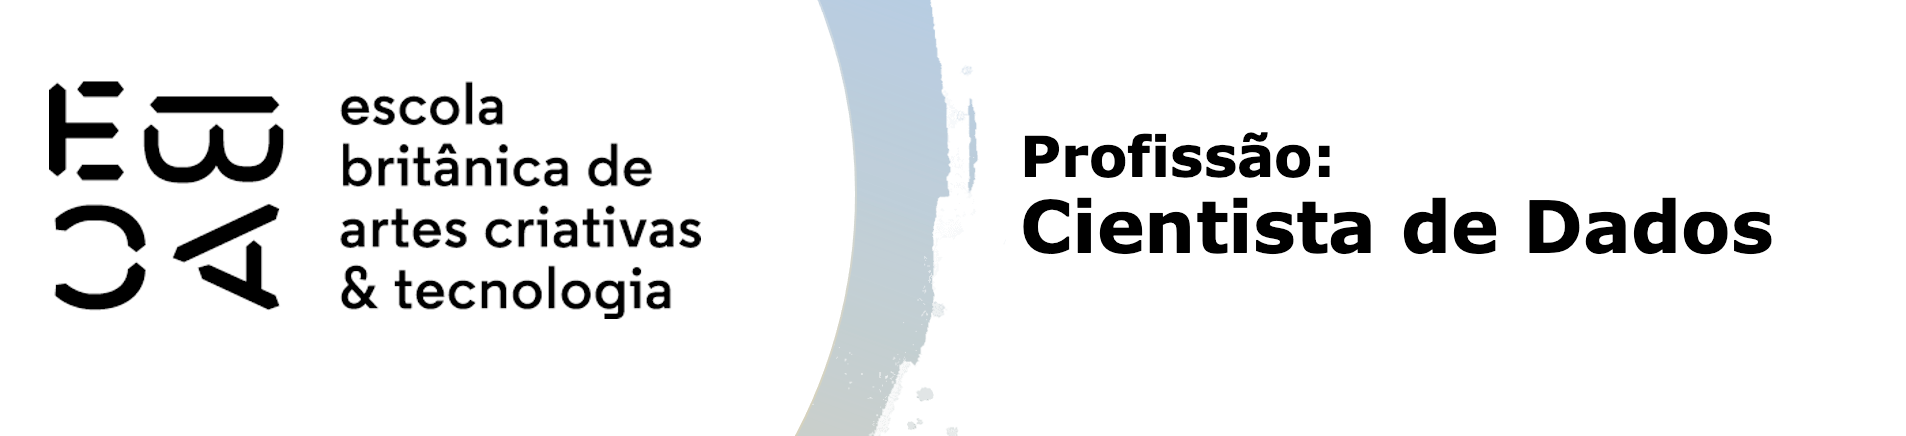

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

Nota: Decidi remover os registros em que *Situação do Crédito* consta com *a calcular*. Fiz isso porque não se sabe se aquele registro vai gerar crédito ou não, apesar de todos constarem como crédito 0. Isso também causa problemas no cálculo do IV da variável mencionada.

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df.drop(index=df[df['Situação do Crédito'] == 'A Calcular'].index, inplace=True)
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
df['Dia da semana'] = df['Data Emissão'].dt.weekday + 1
df['Fim de semana'] = (df['Dia da semana'] == 5) | (df['Dia da semana'] == 6)
df['Dia do mês'] = df['Data Emissão'].dt.day
df['Mês'] = df['Data Emissão'].dt.month
df['Trimestre'] = df['Data Emissão'].dt.quarter

In [4]:
df['Valor NF Q5'] = pd.qcut(df['Valor NF'], 5)
df['Valor NF Q10'] = pd.qcut(df['Valor NF'], 10)
df['Valor NF Q20'] = pd.qcut(df['Valor NF'], 20)
df['Valor NF Q50'] = pd.qcut(df['Valor NF'], 50)

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [6]:
df_b = df.drop(
    columns=[
        'CNPJ emit.', 
        'Emitente', 
        'No.',
        'Data Registro', 
        'Créditos', 
        'Retorno'
    ]
)
metadados = pd.DataFrame({'dtype': df_b.dtypes})
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito', 'papel'] = 'resposta'
metadados['nunique'] = df_b.nunique()
metadados

,dtype,papel,nunique
Data Emissão,datetime64[ns],covariavel,1815
Valor NF,float64,covariavel,33658
Situação do Crédito,category,covariavel,2
Ano,int64,covariavel,5
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
Dia da semana,int64,covariavel,7
Fim de semana,bool,covariavel,2
Dia do mês,int64,covariavel,31


In [7]:
max_categorias = 50
for var in metadados[metadados.papel == 'covariavel'].index:
    if (metadados.loc[var, 'dtype'] in ['datetime64[ns]', 'float64', 'int64']) and \
        (metadados.loc[var, 'nunique'] > max_categorias)\
    :
        quantis = pd.qcut(df_b[var], max_categorias, duplicates='drop')
        metadados.loc[var, 'IV'] = IV(quantis, df_b.flag_credito)
    else:
        metadados.loc[var, 'IV'] = IV(df_b[var], df_b.flag_credito)

In [8]:
pd.set_option('display.float_format',  '{:,.2f}'.format)
metadados.sort_values('IV', ascending=False)

,dtype,papel,nunique,IV
categoria,object,covariavel,9,0.41
Valor NF,float64,covariavel,33658,0.15
Valor NF Q50,category,covariavel,50,0.15
Data Emissão,datetime64[ns],covariavel,1815,0.13
Valor NF Q20,category,covariavel,20,0.12
Valor NF Q10,category,covariavel,10,0.11
Valor NF Q5,category,covariavel,5,0.06
Dia do mês,int64,covariavel,31,0.04
Ano,int64,covariavel,5,0.04
Mês,int64,covariavel,12,0.03


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

As variáveis com maior poder preditivo são:
1. Categoria, com $IV = 0.41$;
1. Valor da nota, com $IV = 0.15$ para 50 quantis;
1. Data de emissão, com $IV = 0.13$ para 50 quantis;

Será que o nosso modelo vai ser instável no tempo?

Note, também como um número maior de categorias mehlora o IV de uma variável! Com 50 quantis, o valor da nota fiscal tem IV 0.15, já com 20, o IV cai para 0.13. Experimente diminuir o valor da variável Python *max_categorias* para ver como o IV do atributo *Data de Emissão* também diminui!

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [9]:
df_trimestre = df_b.groupby(['Ano', 'Trimestre'])

In [10]:
df_trim_cat = df_b.groupby(['categoria', 'Ano', 'Trimestre'])

In [11]:
# Calcula a quantidade de notas por trimestre
qtd_notas_trim = df_trimestre['flag_credito'].count()
#Converte o indice de tuplas (ano, trimestre) para n_trimestres a partir do início
qtd_notas_trim.index = (qtd_notas_trim.index.get_level_values(0) - 2017)*4 + qtd_notas_trim.index.get_level_values(1)

In [12]:
# Calcula a quantidade de notas trimestre agrupada por categoria
qtd_notas_cat_trim = df_trim_cat['flag_credito'].count()
#Converte o indice de tuplas (ano, trimestre) para n_trimestres a partir do início, para cada categoria
qtd_notas_cat_trim = {cat: qtd_notas_cat_trim.loc[cat,:] for cat in qtd_notas_cat_trim.index.get_level_values('categoria').unique()}
for serie in qtd_notas_cat_trim.values():
    serie.index = (serie.index.get_level_values(0) - 2017)*4 + serie.index.get_level_values(1)

In [13]:
# Calcula a quantidade de notas trimestre agrupada por categoria
pct_cred_cat_trim = df_trim_cat['flag_credito'].mean()
#Converte o indice de tuplas (ano, trimestre) para n_trimestres a partir do início, para cada categoria
pct_cred_cat_trim = {cat: pct_cred_cat_trim.loc[cat,:] for cat in pct_cred_cat_trim.index.get_level_values('categoria').unique()}
for serie in pct_cred_cat_trim.values():
    serie.index = (serie.index.get_level_values(0) - 2017)*4 + serie.index.get_level_values(1)

In [14]:
# Anos para etiquetar o gráfico
anos = {item[0] for item in df_trimestre.groups.keys()}
np.arange(min(anos), max(anos)+1)

array([2017, 2018, 2019, 2020, 2021])

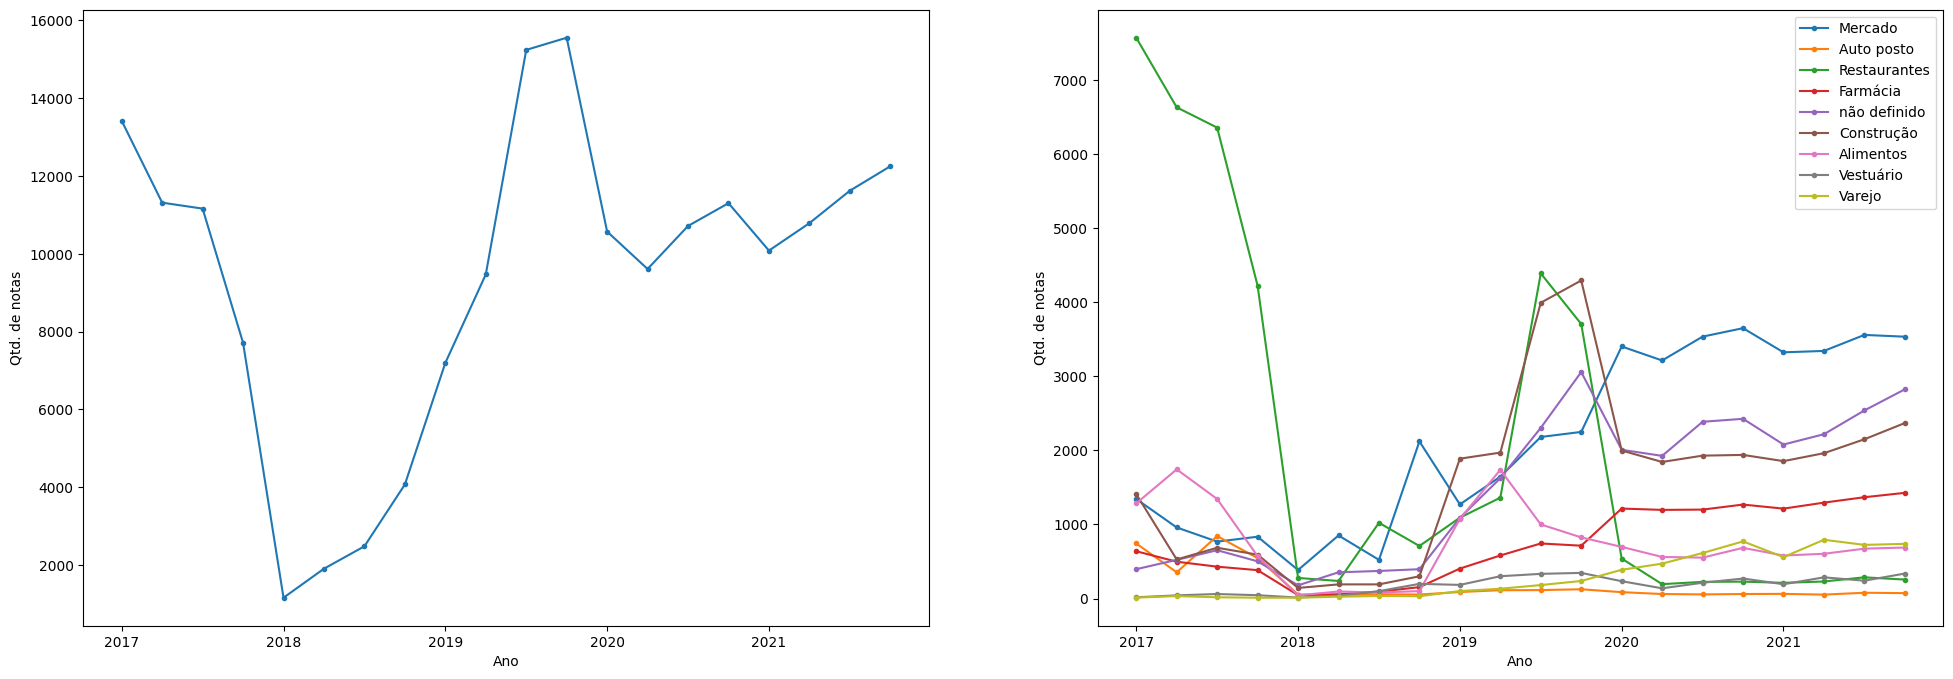

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))

for ax in axs:
    ax.set_xlabel('Ano')
    ax.set_xticks(np.arange(1, 21, 4))
    ax.set_xticklabels(np.arange(min(anos), max(anos)+1))


axs[0].set_ylabel('Qtd. de notas')
axs[1].set_ylabel('Qtd. de notas')

axs[0].plot(qtd_notas_trim.index, qtd_notas_trim, marker='.')
for cat in df_b.categoria.unique():
    axs[1].plot(qtd_notas_cat_trim[cat].index, qtd_notas_cat_trim[cat], label=cat, marker='.')

axs[1].legend()

Alguns pontos sobre a quantidade de notas:
* A categoria *Restaurantes* começa a série histórica com uma quantidade extraordinária de notas, que cai bastante no primeiro semestre de 2018.
* As categorias *Restaurantes* e *Construção* têm um pico de quantidade de notas na segunda metade de 2019.
* A categoria *Mercado* cresceem quantidade de notas até se tornar a líder nesse quesito.
* A partir de 2020, as quantidades de notas por categoria se estabilizam.

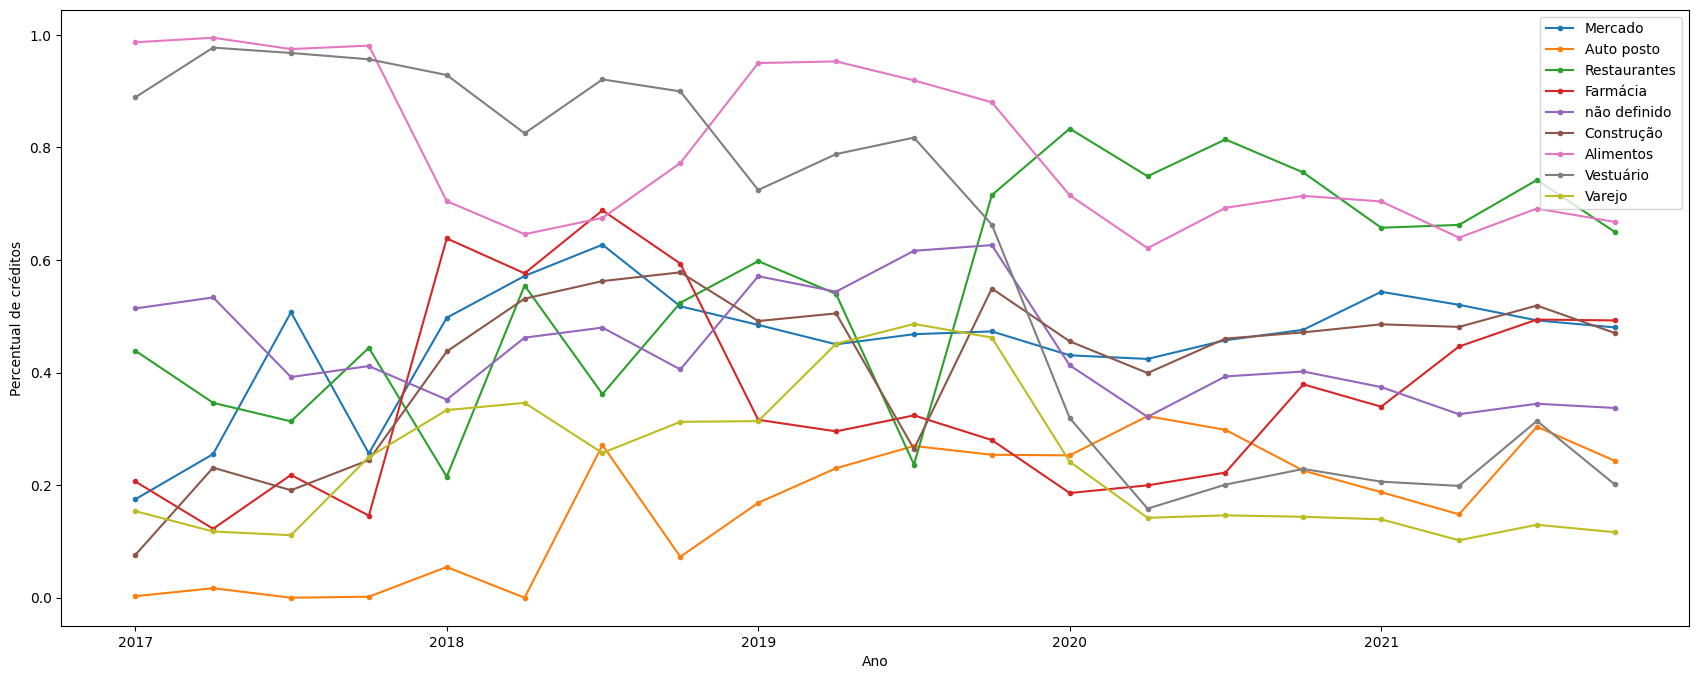

In [16]:
fig, ax = plt.subplots(figsize=(21,8))

ax.set_xlabel('Ano')
ax.set_xticks(np.arange(1, 21, 4))
ax.set_xticklabels(np.arange(min(anos), max(anos)+1))

ax.set_ylabel('Percentual de créditos')

for cat in df_b.categoria.unique():
    ax.plot(pct_cred_cat_trim[cat].index, pct_cred_cat_trim[cat], label=cat, marker='.')

ax.legend()

Pontos com relação à proporção de crédito:
* A maior variação no tempo para a taxa de crédito foi em Vestuário. A partir de meados de 2019 esse percentual cai muito. 
* É possível observar que algumas categorias passam por períodos em que sua taxa de crédito se "descola" da média, como em Farmácia e Alimentos. 
* A partir do segundo semestre de 2020, a proporção de crédito parece mais estável.

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [17]:
def WOE(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')
    rotulo_evento = tab.columns[0]
    rotulo_nao_evento = tab.columns[1]
    tab['odds'] = tab[1] / tab[0]
    return np.log(tab.odds) - np.log(tab.loc['total', 'odds'])


In [18]:
dfs_trimestre = {trimestre: grupo for trimestre, grupo in df_trimestre}
ivs = {key: IV(value['categoria'], value['flag_credito']) for key, value in dfs_trimestre.items()}
woes = {key: WOE(value['categoria'], value['flag_credito']) for key, value in dfs_trimestre.items()}
x = [(trimestre[0] - min(anos))*4 + trimestre[1] for trimestre in dfs_trimestre.keys()]

/home/pedro/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pedro/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


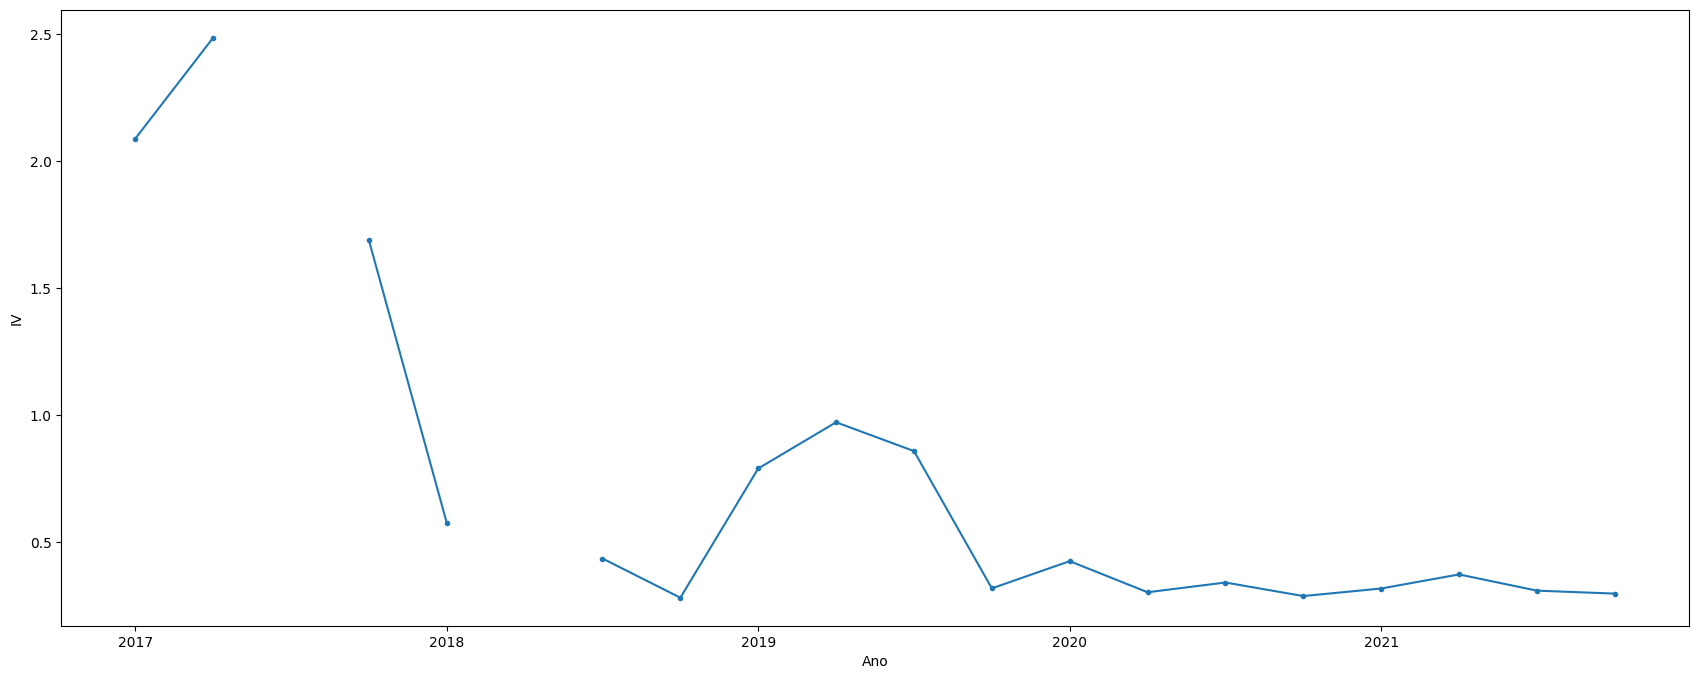

In [26]:
fig, ax = plt.subplots(figsize=(21,8))

ax.set_xlabel('Ano')
ax.set_xticks(np.arange(1, 21, 4))
ax.set_xticklabels(np.arange(min(anos), max(anos)+1))

ax.set_ylabel('IV')

ax.plot(x, ivs.values(), marker='.')

In [27]:
woes

{(2017,
  1): categoria
 Alimentos       4.74
 Auto posto     -5.49
 Construção     -2.07
 Farmácia       -0.92
 Mercado        -1.12
 Restaurantes    0.18
 Varejo         -1.27
 Vestuário       2.51
 não definido    0.49
 total           0.00
 Name: odds, dtype: float64,
 (2017,
  2): categoria
 Alimentos       5.57
 Auto posto     -3.75
 Construção     -0.89
 Farmácia       -1.66
 Mercado        -0.76
 Restaurantes   -0.33
 Varejo         -1.71
 Vestuário       4.07
 não definido    0.44
 total           0.00
 Name: odds, dtype: float64,
 (2017,
  3): categoria
 Alimentos       4.14
 Auto posto      -inf
 Construção     -0.95
 Farmácia       -0.78
 Mercado         0.52
 Restaurantes   -0.29
 Varejo         -1.59
 Vestuário       3.89
 não definido    0.05
 total           0.00
 Name: odds, dtype: float64,
 (2017,
  4): categoria
 Alimentos       4.33
 Auto posto     -5.91
 Construção     -0.73
 Farmácia       -1.37
 Mercado        -0.67
 Restaurantes    0.17
 Varejo         -0.70
 Ve

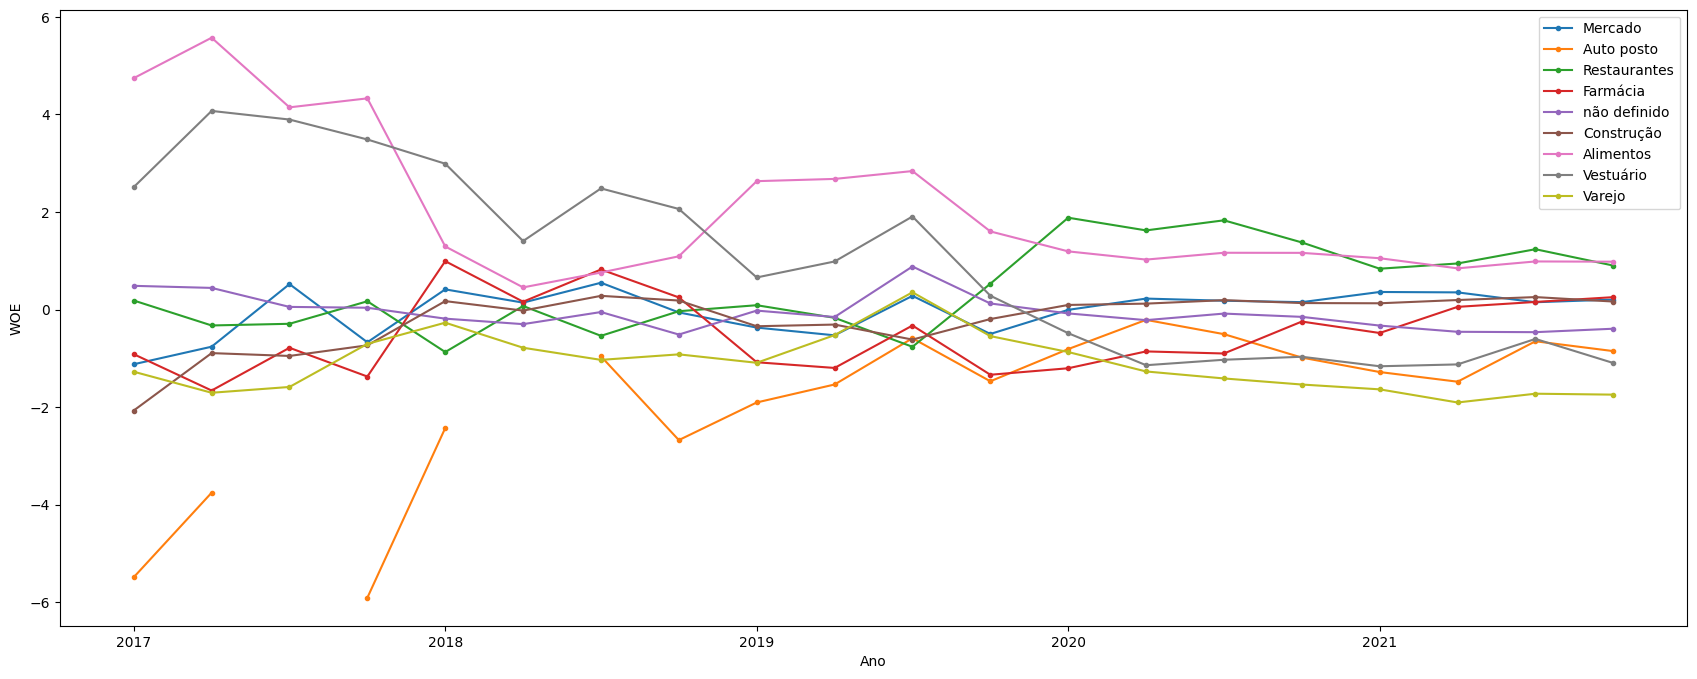

In [30]:
fig, ax = plt.subplots(figsize=(21,8))

ax.set_xlabel('Ano')
ax.set_xticks(np.arange(1, 21, 4))
ax.set_xticklabels(np.arange(min(anos), max(anos)+1))

ax.set_ylabel('WOE')

for cat in df_b.categoria.unique():
    serie = [trimestre[cat] for trimestre in woes.values()]
    ax.plot(x, serie, label=cat, marker='.')

ax.legend()

Aqui concluímos que o Peso de Evidência (WOE, em inglês) também passa a ser estável no tempo apenas a partir do primeiro trimestre de 2020!

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

Com todas essas análises, podemos concluir que a base de dados como um todo só é estável no tempo a partir de 2020. Talvez isso se dê por mudanças no regulamento do programa de cadastro de notas. De qualquer modo, para termos boas previsões, o melhor é descartar dados anteriores a 2020 da base de treino dos modelos.